In [1]:
from IPython.core.interactiveshell import InteractiveShell  #执行该代码可以使得当前nb支持多输出
InteractiveShell.ast_node_interactivity = "all" 
import numpy as np
from datetime import datetime
import pandas as pd 
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
pd.options.display.max_rows = 8  
%matplotlib inline

import os, sys
import statsmodels, arch

print(sys.version)
print('statsmodels version: ',statsmodels.__version__, 
    '; arch version: ', arch.__version__)

3.7.4 (default, Aug  9 2019, 18:34:13) [MSC v.1915 64 bit (AMD64)]
statsmodels version:  0.12.0 ; arch version:  4.19


读取数据

In [2]:
national_debt = pd.read_csv('data/national_debt_5y.csv',header=0,index_col = 0,encoding = 'gb2312')  # 读取股票文件
national_debt['涨跌幅'] = national_debt['涨跌幅'].str.strip("%").astype(float)/100
national_debt.head()
national_debt.describe()

,开盘,收盘,高,低,涨跌幅
日期,,,,,
2016/1/21,2.683,2.700,2.703,2.680,0.0078
2016/1/22,2.705,2.689,2.705,2.682,-0.0041
2016/1/25,2.750,2.694,2.750,2.680,0.0019
2016/1/26,2.703,2.738,2.740,2.690,0.0163
2016/1/27,2.763,2.774,2.783,2.763,0.0131


,开盘,收盘,高,低,涨跌幅
count,1563.000000,1563.000000,1563.000000,1563.000000,1.563000e+03
mean,3.041862,3.022280,3.049060,3.010074,4.478567e-07
std,0.419688,0.420101,0.418939,0.420670,9.475657e-03
min,1.740000,1.740000,1.740000,1.740000,-5.850000e-02
25%,2.746000,2.712000,2.750000,2.697000,-4.350000e-03
50%,3.012000,2.993000,3.018000,2.983000,0.000000e+00
75%,3.261000,3.234000,3.269000,3.219000,4.300000e-03
max,4.000000,3.968000,4.000000,3.952000,6.070000e-02


单位根检验

In [5]:
from arch.unitroot import ADF
print(ADF(national_debt.开盘))

   Augmented Dickey-Fuller Results   
Test Statistic                 -2.162
P-value                         0.220
Lags                               21
-------------------------------------

Trend: Constant
Critical Values: -3.43 (1%), -2.86 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


p-value大于0.1，拒绝了序列 x 的平稳性。

data length is %d 1562


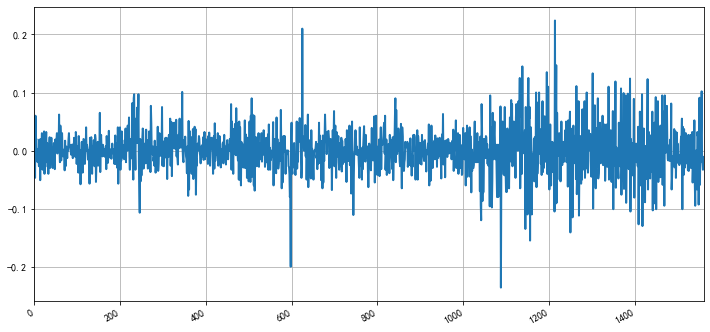

   Augmented Dickey-Fuller Results   
Test Statistic                 -6.791
P-value                         0.000
Lags                               20
-------------------------------------

Trend: Constant
Critical Values: -3.43 (1%), -2.86 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


In [37]:
#可以看到序列自相关性是很高的，从序列表现来看也不够平稳性，所以需要做一阶差分
data = pd.Series(np.diff(national_debt.开盘))
#data = pd.Series.diff(national_debt.开盘)
data.index = pd.date_range(data.index[0],periods=len(data))
print("data length is %d",len(data))
data.plot(use_index=False,figsize=(12,6),linewidth=2,grid=True)
plt.show()

print(ADF(data))

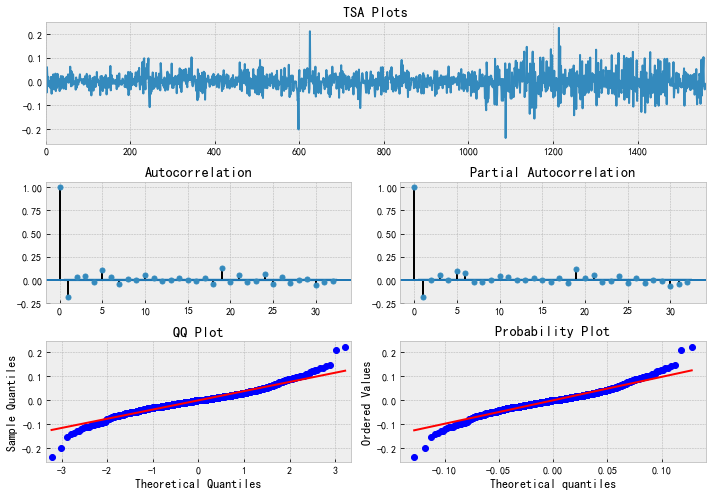

In [12]:
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import statsmodels.formula.api as smf
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False 

from scipy import stats

def tsplot(y, lags=None, figsize=(10, 7), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        qq_ax = plt.subplot2grid(layout, (2, 0))
        pp_ax = plt.subplot2grid(layout, (2, 1))
        
        y.plot(ax=ts_ax)
        ts_ax.set_title('TSA Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)
        sm.qqplot(y, line='s', ax=qq_ax)
        qq_ax.set_title('QQ Plot')        
        stats.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)
        
        plt.tight_layout()

tsplot(data)

QQ plot（quantile-quantile plot），也称正态概率图（normal probability plot），分位数-分位数图,是常用的统计分析用图，
用于检查一组数据是否服从正态分布，是实数与正态分布数据间的函数关系的散点图。
如果这组实数服从正态分布，正态概率图就是一条直线。通常，概率图也可用于确定一组数据是否服从任一已知分布，如二项分布或泊松分布。

p–p图绘制两个累积分布函数（CDF）的相对位置：这是一个概率图，用于评估两个数据集之间的一致程度，
并绘制两个累积分布函数的相对位置。P-P图被广泛用于评估分布的偏斜度。

截尾是指时间序列的自相关函数（ACF）或偏自相关函数（PACF）在某阶后均为0的性质，在大于某个常数k后快速趋于0为k阶截尾；

拖尾是ACF或PACF并不在某阶后均为0的性质，始终有非零取值，不会在k大于某个常数后就恒等于零(或在0附近随机波动)。

AR模型：自相关系数拖尾，偏自相关系数截尾；

MA模型：自相关系数截尾，偏自相关函数拖尾；

ARMA模型：自相关函数和偏自相关函数均拖尾。


## ARMA 模型

In [56]:
# 移动平均图
def draw_trend(timeSeries, size):
    f = plt.figure(facecolor='white')
    # 对size个数据进行移动平均
    rol_mean = timeSeries.rolling(window=size).mean()
    # 对size个数据进行加权移动平均
    rol_weighted_mean = pd.DataFrame.ewm(timeSeries, span=size).mean()

    timeSeries.plot(color='blue', label='Original')
    rol_mean.plot(color='red', label='Rolling Mean')
    rol_weighted_mean.plot(color='black', label='Weighted Rolling Mean')
    plt.legend(loc='best')
    plt.title('Rolling Mean')
    plt.show()

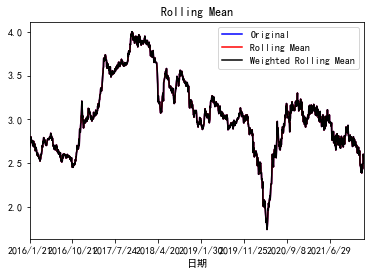

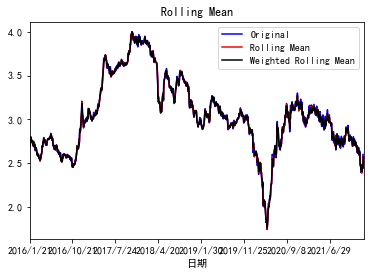

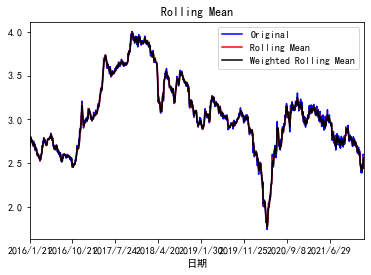

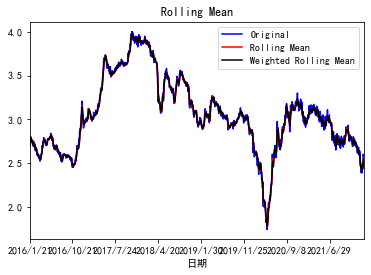

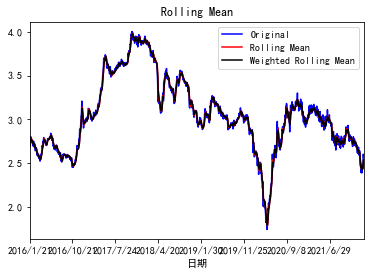

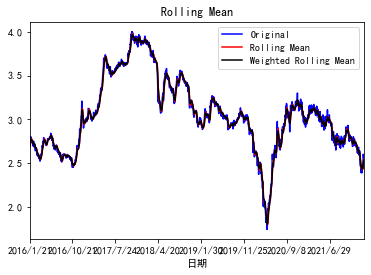

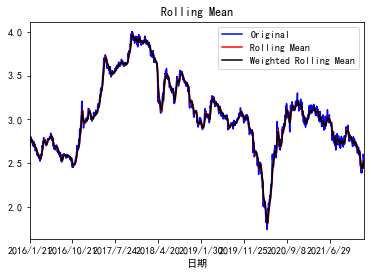

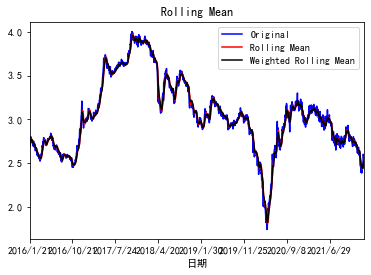

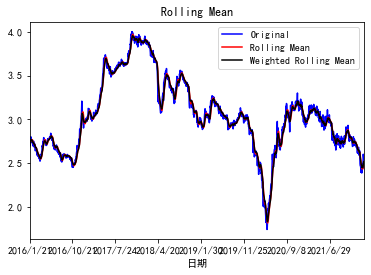

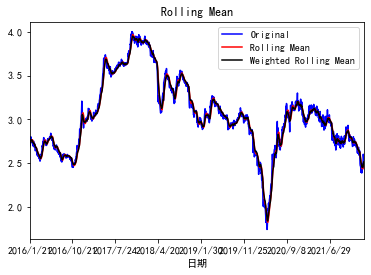

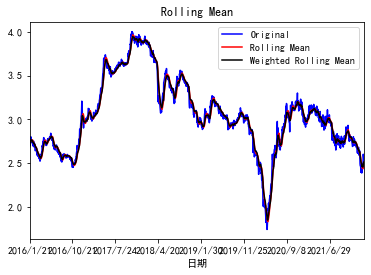

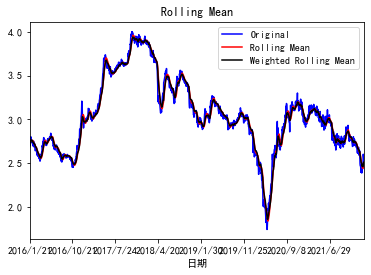

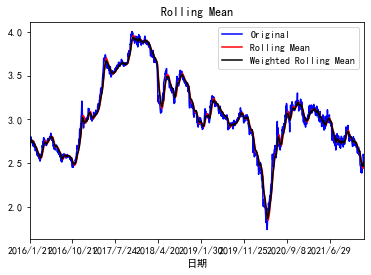

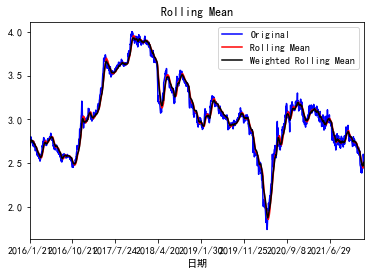

In [59]:
for i in range(1,15):
    
    draw_trend(national_debt.开盘, i)


In [43]:
from statsmodels.tsa.stattools import adfuller
def testStationarity(ts):
    dftest = adfuller(ts)
    print(dftest)
    # 对上述函数求得的值进行语义描述
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    return dfoutput

ts_log = np.log(national_debt.开盘)
rol_mean = ts_log.rolling(window=12).mean()
rol_mean.dropna(inplace=True)
ts_diff_1 = rol_mean.diff(1)
ts_diff_1.dropna(inplace=True)
testStationarity(ts_diff_1)

(-6.76019943445605, 2.8048666084581263e-09, 24, 1526, {'1%': -3.4346424863111396, '5%': -2.8634358661653803, '10%': -2.5677793320839823}, -16047.307387509936)


Test Statistic                -6.760199e+00
p-value                        2.804867e-09
#Lags Used                     2.400000e+01
Number of Observations Used    1.526000e+03
Critical Value (1%)           -3.434642e+00
Critical Value (5%)           -2.863436e+00
Critical Value (10%)          -2.567779e+00
dtype: float64

In [45]:
from statsmodels.tsa.arima_model import ARMA
model = ARMA(ts_diff_1, order=(1, 1)) 
result_arma = model.fit( disp=-1, method='css')

result_arma.summary()

D:\Anaconda3\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                     开盘   No. Observations:                 1551
Model:                     ARMA(1, 1)   Log Likelihood                7844.712
Method:                           css   S.D. of innovations              0.002
Date:                Fri, 11 Mar 2022   AIC                         -15681.423
Time:                        15:47:55   BIC                         -15660.039
Sample:                             1   HQIC                        -15673.470
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const      -4.418e-05      0.001     -0.085      0.933      -0.001       0.001
ar.L1.开盘       0.9372      0.010     97.390      0.000       0.918       0.956
ma.L1.开盘      -0.1582      0.026     -6.097      0.000      -0.209      -0.107
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0670           +0.0000j            1.0670            0.0000
MA.1            6.3224           +0.0000j            6.3224            0.0000
-----------------------------------------------------------------------------
"""

In [51]:
predict_ts = result_arma.predict()
# 一阶差分还原
diff_shift_ts = ts_diff_1.shift(1)
diff_recover_1 = predict_ts.add(diff_shift_ts)
# 再次一阶差分还原
rol_shift_ts = rol_mean.shift(1)
diff_recover = diff_recover_1.add(rol_shift_ts)
# 移动平均还原
rol_sum = ts_log.rolling(window=11).sum()
rol_recover = diff_recover*12 - rol_sum.shift(1)
# 对数还原
log_recover = np.exp(rol_recover)
log_recover.dropna(inplace=True)
print("the length of log_recover is %d ",len(log_recover))


the length of log_recover is %d  1550


这里的数据相比较原始数据的1563少了13个，原因是一位用来做差分，12位用来计算移动平均

<Figure size 432x288 with 0 Axes>

Text(0.5, 1.0, 'national debt Price Prediction')

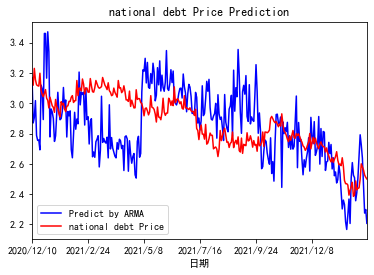

In [50]:
plt.figure(facecolor='white')
log_recover[len(log_recover) - 300:].plot(color='blue', label='Predict by ARMA')
pd.Series(national_debt.开盘[len(national_debt.开盘)-300:]).plot(color='red', label='national debt Price')
plt.legend(loc='best')
plt.title('national debt Price Prediction')
plt.show()

In [55]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

##########evaluate##############
# calculate MSE 均方误差 ---> E[(预测值-真实值)^2] (预测值减真实值求平方后求均值)
mse = mean_squared_error(log_recover,national_debt.开盘[13:])
# calculate RMSE 均方根误差--->sqrt[MSE]    (对均方误差开方)
rmse = math.sqrt(mean_squared_error(log_recover, national_debt.开盘[13:]))
# calculate MAE 平均绝对误差----->E[|预测值-真实值|](预测值减真实值求绝对值后求均值）
mae = mean_absolute_error(log_recover, national_debt.开盘[13:])
print('均方误差: %.6f' % mse)
print('均方根误差: %.6f' % rmse)
print('平均绝对误差: %.6f' % mae)

均方误差: 0.155850
均方根误差: 0.394779
平均绝对误差: 0.295257
